## How does this work?
Modern machine learning algorithms employ a wide variety of techniques. Scaling these requires a similarly wide variety of different approaches. Generally solutions fall into the following three categories

### Parallelize Scikit-Learn Directly
Scikit-Learn already provides parallel computing on a single machine with Joblib. Dask extends this parallelism to many machines in a cluster. This works well for modest data sizes but large computations, such as random forests, hyper-parameter optimization, and more.

In [ ]:
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend

client = Client()  # Connect to a Dask Cluster

with parallel_backend('dask'):
    # Your normal scikit-learn code here

### Reimplement Scalable Algorithms with Dask Array
Some machine learning algorithms are easy to write down as Numpy algorithms. In these cases we can replace Numpy arrays with Dask arrays to achieve scalable algorithms easily. This is employed for linear models, pre-processing, and clustering.



### Train Models on Large Datasets
Most estimators in scikit-learn are designed to work with NumPy arrays or scipy sparse matricies. These data structures must fit in the RAM on a single machine.

Estimators implemented in Dask-ML work well with Dask Arrays and DataFrames. This can be much larger than a single machine’s RAM. They can be distributed in memory on a cluster of machines.

In [1]:
%matplotlib inline

In [1]:
from dask.distributed import Client

# Scale up: connect to your own cluster with more resources
# see http://dask.pydata.org/en/latest/setup.html
client = Client('192.168.1.9:8786')
client

Client Scheduler: tcp://192.168.1.9:8786 Dashboard: http://192.168.1.9:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.49 GB


In [2]:
import dask_ml.datasets
import dask_ml.cluster
import matplotlib.pyplot as plt

In [3]:
# Scale up: increase n_samples or n_features
X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
                                   chunks=100000,
                                   random_state=0,
                                   centers=3)
X = X.persist()
X

dask.array<concatenate, shape=(1000000, 2), dtype=float64, chunksize=(100000, 2)>

In [4]:
km = dask_ml.cluster.KMeans(n_clusters=3, init_max_iter=2, oversampling_factor=10)
km.fit(X)

KMeans(algorithm='full', copy_x=True, init='k-means||', init_max_iter=2,
    max_iter=300, n_clusters=3, n_jobs=1, oversampling_factor=10,
    precompute_distances='auto', random_state=None, tol=0.0001)

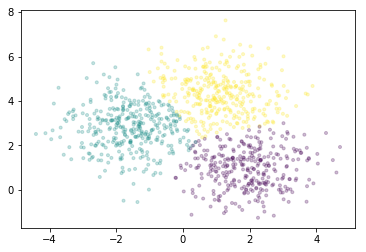

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[::1000, 0], X[::1000, 1], marker='.', c=km.labels_[::1000],
           cmap='viridis', alpha=0.25);

In [27]:
from sklearn.datasets import make_circles
from sklearn.utils import shuffle
import pandas as pd

from timeit import default_timer as tic
import sklearn.cluster
import dask_ml.cluster
#import seaborn as sns

Ns = [2500, 5000, 7500, 10000, 12000]
Ns = [1000,2000]
#X, y = make_circles(n_samples=10_000, noise=0.05, random_state=0, factor=0.5)
#X, y = shuffle(X, y)

timings = []
#for n in Ns:
    #X, y = make_circles(n_samples=n, random_state=n, noise=0.5, factor=0.5)
#    X, y = dask_ml.datasets.make_blobs(n_samples=1000000,
#                                   chunks=100000,
#                                   random_state=0,
#                                   centers=3)
#    t1 = tic()
#    sklearn.cluster.KMeans(n_clusters=3).fit(X)
#    timings.append(('Scikit-Learn (exact)', n, tic() - t1))
#    t1 = tic()
#    dask_ml.cluster.KMeans(n_clusters=3).fit(X)
#    timings.append(('dask-ml (approximate)', n, tic() - t1))
timings = []
for n in Ns:
    X, y = make_circles(n_samples=n, random_state=n, noise=0.5, factor=0.5)
    client.scatter(X)
    client.scatter(y)
    t1 = tic()
    sklearn.cluster.SpectralClustering(n_clusters=2).fit(X)
    timings.append(('Scikit-Learn (exact)', n, tic() - t1))
    t1 = tic()
    dask_ml.cluster.SpectralClustering(n_clusters=2, n_components=100).fit(X)
    timings.append(('dask-ml (approximate)', n, tic() - t1))




In [29]:
df = pd.DataFrame(timings, columns=['method', 'Number of Samples', 'Fit Time'])
#sns.factorplot(x='Number of Samples', y='Fit Time', hue='method',
#               data=df, aspect=1.5)
df.head()

sk = df[df['method']=='Scikit-Learn (exact)']
dk = df[df['method']=='dask-ml (approximate)']
sk.head()
#dk.head()

#plt.plot( dk['Number of Samples'].values, dk['Fit Time'].values, color='green')
#plt.plot(sk['Number of Samples'].values,sk['Fit Time'].values, color='blue')
#plt.show()

,method,Number of Samples,Fit Time
0,Scikit-Learn (exact),1000,0.582774
2,Scikit-Learn (exact),2000,1.876841


### Exercise 1
Try to change the number of features, the number of samples and the number of workers and see what happen on the dask dashboard